# Training the Mask Detector

Tutorial = [link](https://www.youtube.com/watch?v=Ax6P93r32KU&ab_channel=BalajiSrinivasan)

## Import Modules

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths

import matplotlib.pyplot as plt
import numpy as np
import os

## Data Preprocessing

### Global Variables

In [9]:
INIT_LR = 1e-4 # Learning rate
EPOCHS = 25    # Epochs
BS = 32        # Batch size

DIR = r"./dataset/"
CATEGORY = ['Masked', "Unmasked"]

In [6]:
print("[INFO] loading images ...")

data = []
labels = []

for category in CATEGORY:
    path = os.path.join(DIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)
        
print("[DONE]")

[INFO] loading images ...


### Label Encoding

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
train_X, test_X, train_y, test_y = train_test_split(data, labels, 
                                                    test_size=0.20, 
                                                    stratify=labels, 
                                                    random_state=42)

## Training

### Construct Training Image Generator for Data Augmentation

In [10]:
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

### Load MobileNetV2 Network

In [11]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 16s 2us/step


### Construct Head Model on Top of Base Model

In [12]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

### Place the Head Model on Top of Base Model

In [13]:
model = Model(inputs=base_model.input, outputs=head_model)

### Loop Through All layers

In [15]:
for layer in base_model.layers:
    layer.trainable = False

### Compile the model

In [18]:
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

print("[DONE]")

[INFO] compiling model...
[DONE]


C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Training head of the network

In [19]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(train_X, train_y, batch_size=BS),
    steps_per_epoch=len(train_X) // BS,
    validation_data=(test_X, test_y),
    validation_steps=len(test_X) // BS,
    epochs=EPOCHS
)
print("[DONE]")

[INFO] training head...
Epoch 1/25
15/15 [==============================] - 15s 795ms/step - loss: 0.6245 - accuracy: 0.6976 - val_loss: 0.3669 - val_accuracy: 0.9677
Epoch 2/25
15/15 [==============================] - 11s 751ms/step - loss: 0.3598 - accuracy: 0.8920 - val_loss: 0.1915 - val_accuracy: 0.9839
Epoch 3/25
15/15 [==============================] - 11s 751ms/step - loss: 0.2294 - accuracy: 0.9503 - val_loss: 0.1114 - val_accuracy: 0.9919
Epoch 4/25
15/15 [==============================] - 12s 763ms/step - loss: 0.1405 - accuracy: 0.9741 - val_loss: 0.0751 - val_accuracy: 0.9919
Epoch 5/25
15/15 [==============================] - 11s 751ms/step - loss: 0.1089 - accuracy: 0.9892 - val_loss: 0.0538 - val_accuracy: 0.9919
Epoch 6/25
15/15 [==============================] - 11s 758ms/step - loss: 0.0869 - accuracy: 0.9827 - val_loss: 0.0420 - val_accuracy: 0.9919
Epoch 7/25
15/15 [==============================] - 11s 759ms/step - loss: 0.0714 - accuracy: 0.9870 - val_loss: 0.034

### Predictions on Testing Set

In [20]:
print("[INFO] evaluating network...")

predIdxs = model.predict(test_X, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print("[DONE]")

[INFO] evaluating network...


### Show Classification Report

In [21]:
print(classification_report(test_y.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

      Masked       1.00      1.00      1.00        60
    Unmasked       1.00      1.00      1.00        64

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124



### Serialize the Model (Saving the Model)

In [22]:
print("[INFO] saving the model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving the model...


C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Plot Training Loss and Accuracy

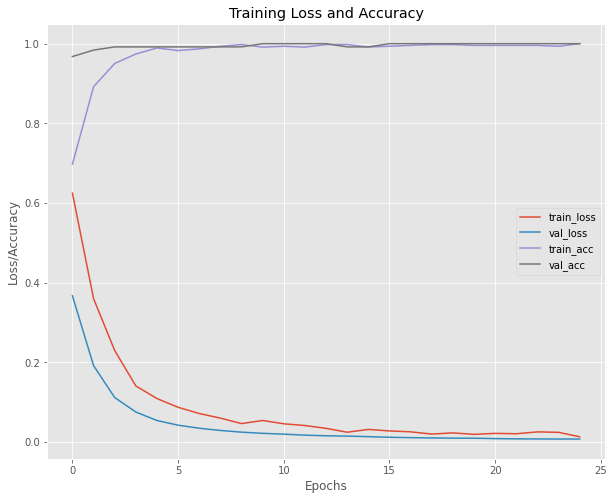

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, N), H.history['loss'], label="train_loss")
plt.plot(np.arange(0, N), H.history['val_loss'], label="val_loss")
plt.plot(np.arange(0, N), H.history['accuracy'], label="train_acc")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("history_plot.png")